# 概要

ここではVision transformerを使った骨のレントゲン画像の分類を行う。

使用するデータセットは[MURA](https://stanfordmlgroup.github.io/competitions/mura/)で、
今回は手の画像からpositive or negativeを判別できないか試す。



v2からの変更点

pretrained=Trueにし、ファインチューニングしてみる。

必要なライブラリをpipでインストールしておくと良い。

In [1]:
!pip install vit_pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.5 MB/s eta 0:00:00


## 先述のデータセットから構成をVit用に配置し直したものをダウンロードする。

ダウンロードはこちらから

- [trainデータ](https://drive.google.com/drive/folders/1t6IzmwX-gf8UjeJohc6WJ0ZWo_2KuApR?usp=sharing)

- [valデータ](https://drive.google.com/drive/folders/13Nrr4rgSNFpQS2vNP7LcYeL8Ar9RFhvv?usp=sharing)

## データセットを自身のドライブにアップロードする

ドライブにアップロードした後はColab上でGoogleドライブをマウントする

# ライブラリのインストール

In [2]:
from __future__ import print_function

import glob
import os
import random
import cv2
# Google Colab環境下ならcv2の代わりにこれを使用する
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

# 学習条件、ランダムシードの設定

In [3]:
# Training settings
epochs = 100
# lr = 0.01
lr = 1e-3
gamma = 0.7
seed = 42
save_path = "/content/drive/MyDrive/Colab Notebooks/花岡さん/trained_model/vit_pytorch_v3.pth"

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
# GPUの設定
device = 'cuda'

# 学習データセットの設定

ドライブにアップしたtrainデータとvalデータのパスをコピーする

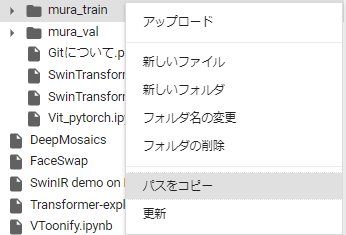

In [6]:
# コピーしたパスを貼り付ける
train_dataset_dir = Path('/content/drive/MyDrive/Colab Notebooks/花岡さん/mura_train_v2')
val_dataset_dir = Path('/content/drive/MyDrive/Colab Notebooks/花岡さん/mura_val_v2')

上手く読み込めているか確認

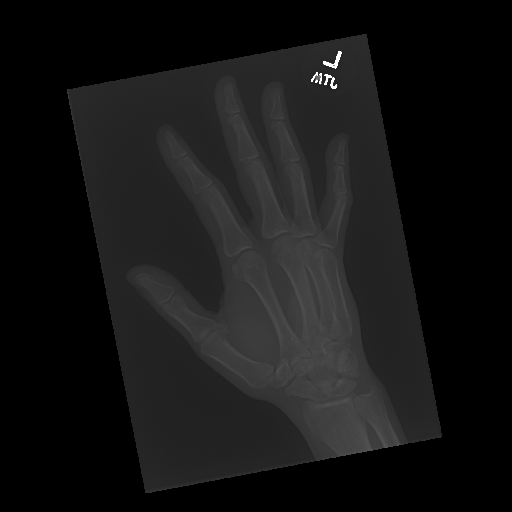

In [7]:
# 必要に応じてパスを変更する
img_file = '/content/drive/MyDrive/Colab Notebooks/花岡さん/mura_train_v2/negative/patient00050_image1.png'
img = cv2.imread(img_file)
cv2_imshow(img)

# データセットの前処理

In [8]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

# データセットのロード

In [9]:
train_data = datasets.ImageFolder(train_dataset_dir,train_transforms)
valid_data = datasets.ImageFolder(val_dataset_dir, val_transforms)

データをバッチに分ける。

今回バッチサイズは16にするが、メモリが足らない場合は数字をあげる。

In [10]:
train_loader = DataLoader(dataset = train_data, batch_size=64, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=64, shuffle=True)

# Vitモデルのロード


In [11]:
# model_names = timm.list_models(pretrained=False)
# ファインチューニングしたい場合はpretrained=True
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

今回は'vit_base_patch16_224_in21k'を選んでみる

In [12]:
# model = timm.create_model('vit_base_patch16_224_in21k', pretrained=False, num_classes=2)
# ファインチューニングしたい場合はpretrained=True
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# Vit学習

損失関数、活性化関数の設定をする。

今回はクロスエントロピーロス、アダムを使う。

In [13]:
# loss function
criterion = nn.CrossEntropyLoss()
# criterion = nn.HuberLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

学習ループを設定し、実行していく

In [14]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.3163 - acc: 0.6714 - val_loss : 0.7022 - val_acc: 0.6069



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.5810 - acc: 0.7361 - val_loss : 0.6722 - val_acc: 0.6069



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6582 - acc: 0.6741 - val_loss : 0.6552 - val_acc: 0.6229



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6012 - acc: 0.7259 - val_loss : 0.6511 - val_acc: 0.6310



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5931 - acc: 0.7288 - val_loss : 0.9472 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6112 - acc: 0.7208 - val_loss : 0.6685 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.5900 - acc: 0.7364 - val_loss : 0.7670 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.5936 - acc: 0.7368 - val_loss : 0.6648 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.5926 - acc: 0.7237 - val_loss : 0.6815 - val_acc: 0.6229



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.5805 - acc: 0.7358 - val_loss : 0.6846 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5952 - acc: 0.7260 - val_loss : 0.6636 - val_acc: 0.5962



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.5872 - acc: 0.7354 - val_loss : 0.7118 - val_acc: 0.6069



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.5829 - acc: 0.7357 - val_loss : 0.7906 - val_acc: 0.5872



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6042 - acc: 0.7221 - val_loss : 0.6715 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.5853 - acc: 0.7368 - val_loss : 0.7364 - val_acc: 0.6096



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.5826 - acc: 0.7303 - val_loss : 0.6668 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5821 - acc: 0.7352 - val_loss : 0.8444 - val_acc: 0.5962



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6168 - acc: 0.7198 - val_loss : 0.7603 - val_acc: 0.6069



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5989 - acc: 0.7359 - val_loss : 0.6894 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5804 - acc: 0.7362 - val_loss : 0.6816 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5831 - acc: 0.7361 - val_loss : 0.7153 - val_acc: 0.6096



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.5804 - acc: 0.7361 - val_loss : 0.7506 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.5791 - acc: 0.7360 - val_loss : 0.7363 - val_acc: 0.6069



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.5808 - acc: 0.7367 - val_loss : 0.6946 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.5710 - acc: 0.7366 - val_loss : 0.7300 - val_acc: 0.6203



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.5740 - acc: 0.7367 - val_loss : 0.7097 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.5753 - acc: 0.7365 - val_loss : 0.7688 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.5779 - acc: 0.7365 - val_loss : 0.7501 - val_acc: 0.6042



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.5756 - acc: 0.7364 - val_loss : 0.6762 - val_acc: 0.6229



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.5722 - acc: 0.7362 - val_loss : 0.6919 - val_acc: 0.6096



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.5733 - acc: 0.7366 - val_loss : 0.7061 - val_acc: 0.6203



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.5716 - acc: 0.7364 - val_loss : 0.7226 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.5685 - acc: 0.7365 - val_loss : 0.6689 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.5723 - acc: 0.7365 - val_loss : 0.7304 - val_acc: 0.6069



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.5692 - acc: 0.7366 - val_loss : 0.6891 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.5692 - acc: 0.7363 - val_loss : 0.7009 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.5701 - acc: 0.7367 - val_loss : 0.6878 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.5692 - acc: 0.7368 - val_loss : 0.6707 - val_acc: 0.6203



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.5720 - acc: 0.7363 - val_loss : 0.7343 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.5737 - acc: 0.7366 - val_loss : 0.6933 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.5698 - acc: 0.7367 - val_loss : 0.6790 - val_acc: 0.6203



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5710 - acc: 0.7364 - val_loss : 0.7433 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.5719 - acc: 0.7366 - val_loss : 0.6691 - val_acc: 0.6256



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.5720 - acc: 0.7363 - val_loss : 0.7198 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.5708 - acc: 0.7363 - val_loss : 0.6814 - val_acc: 0.6042



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.5692 - acc: 0.7367 - val_loss : 0.6928 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.5693 - acc: 0.7362 - val_loss : 0.6710 - val_acc: 0.6229



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.5697 - acc: 0.7363 - val_loss : 0.7086 - val_acc: 0.6069



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.5682 - acc: 0.7363 - val_loss : 0.7081 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.5684 - acc: 0.7363 - val_loss : 0.6990 - val_acc: 0.6256



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.5678 - acc: 0.7365 - val_loss : 0.6925 - val_acc: 0.6016



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.5696 - acc: 0.7363 - val_loss : 0.7154 - val_acc: 0.6069



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.5704 - acc: 0.7364 - val_loss : 0.6861 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.5721 - acc: 0.7366 - val_loss : 0.6988 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.5692 - acc: 0.7368 - val_loss : 0.7089 - val_acc: 0.6042



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.5708 - acc: 0.7368 - val_loss : 0.7019 - val_acc: 0.6042



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.5704 - acc: 0.7366 - val_loss : 0.7025 - val_acc: 0.6042



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.5692 - acc: 0.7366 - val_loss : 0.7122 - val_acc: 0.5962



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.5715 - acc: 0.7362 - val_loss : 0.7219 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.5716 - acc: 0.7366 - val_loss : 0.7096 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.5696 - acc: 0.7365 - val_loss : 0.7087 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.5694 - acc: 0.7368 - val_loss : 0.6868 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.5693 - acc: 0.7365 - val_loss : 0.7487 - val_acc: 0.6016



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.5693 - acc: 0.7366 - val_loss : 0.7050 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.5706 - acc: 0.7365 - val_loss : 0.7113 - val_acc: 0.6203



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.5714 - acc: 0.7365 - val_loss : 0.7038 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.5678 - acc: 0.7365 - val_loss : 0.7151 - val_acc: 0.6096



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.5674 - acc: 0.7358 - val_loss : 0.7064 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.5703 - acc: 0.7363 - val_loss : 0.6595 - val_acc: 0.6203



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.5712 - acc: 0.7367 - val_loss : 0.6700 - val_acc: 0.6042



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.5683 - acc: 0.7367 - val_loss : 0.6923 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.5701 - acc: 0.7371 - val_loss : 0.6708 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.5677 - acc: 0.7363 - val_loss : 0.6933 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.5746 - acc: 0.7361 - val_loss : 0.6699 - val_acc: 0.6149



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.5763 - acc: 0.7369 - val_loss : 0.6854 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.5707 - acc: 0.7366 - val_loss : 0.6757 - val_acc: 0.6256



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.5669 - acc: 0.7367 - val_loss : 0.6821 - val_acc: 0.6203



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.5698 - acc: 0.7360 - val_loss : 0.7118 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.5690 - acc: 0.7366 - val_loss : 0.6733 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.5692 - acc: 0.7365 - val_loss : 0.7015 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.5676 - acc: 0.7364 - val_loss : 0.7170 - val_acc: 0.5989



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.5690 - acc: 0.7367 - val_loss : 0.6936 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.5681 - acc: 0.7363 - val_loss : 0.7040 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.5687 - acc: 0.7364 - val_loss : 0.6883 - val_acc: 0.6256



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.5739 - acc: 0.7369 - val_loss : 0.6868 - val_acc: 0.5989



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.5704 - acc: 0.7360 - val_loss : 0.6887 - val_acc: 0.6229



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.5751 - acc: 0.7366 - val_loss : 0.7271 - val_acc: 0.6096



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.5706 - acc: 0.7361 - val_loss : 0.7009 - val_acc: 0.6069



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.5721 - acc: 0.7363 - val_loss : 0.7207 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.5703 - acc: 0.7367 - val_loss : 0.6982 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.5668 - acc: 0.7361 - val_loss : 0.6607 - val_acc: 0.6229



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.5673 - acc: 0.7356 - val_loss : 0.6958 - val_acc: 0.6176



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.5710 - acc: 0.7364 - val_loss : 0.7186 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.5681 - acc: 0.7366 - val_loss : 0.6917 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.5721 - acc: 0.7366 - val_loss : 0.6905 - val_acc: 0.6096



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.5729 - acc: 0.7367 - val_loss : 0.7431 - val_acc: 0.6042



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.5706 - acc: 0.7366 - val_loss : 0.7106 - val_acc: 0.6123



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.5686 - acc: 0.7352 - val_loss : 0.6650 - val_acc: 0.6256



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.5666 - acc: 0.7368 - val_loss : 0.7355 - val_acc: 0.6042



  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.5679 - acc: 0.7366 - val_loss : 0.7396 - val_acc: 0.6149



# 学習結果の可視化

<ipython-input-15-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


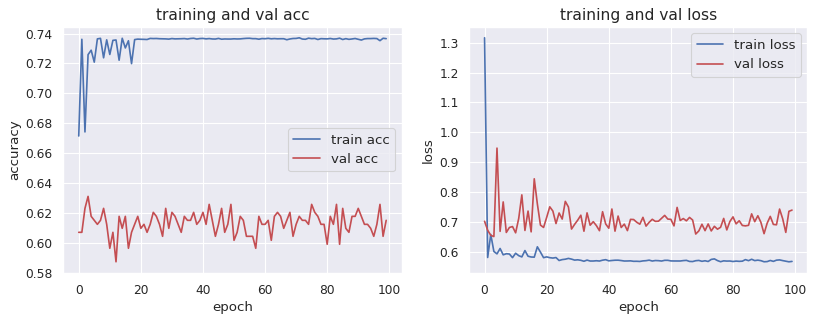

In [15]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

# モデルの出力

In [16]:
torch.save(model.state_dict(), save_path)

# 結果と考察

## 結果

- val acc：0.61程度なので精度としては微妙(v1よりは上がった)
- train acc:073程度なので過学習というよりは局所最適解の可能性（v1よりも正解率はは上がった）
- 最低でもval acc:0.7程度無いと希望が持てないレベル

## 考察

- パーの形のみのデータセットにした結果、正解率は上がった。
- 各画像に濃淡差があるので、前処理しても良いかもしれない。
- 他のモデルも検討してみる。（大きな改善は見込めない）